# Comparación de Curvas de Entrenamiento con Diferentes Inicializaciones de Pesos en un MLP

En este ejemplo, vamos a entrenar un MLP en el dataset MNIST bajo diferentes esquemas de inicialización de pesos. Compararemos las siguientes inicializaciones:

1. Todos los pesos en $0$
2. Todos los pesos en $1$
3. Distribución normal $N(0,1)$
4. Distribución normal Xavier (Glorot)
5. Distribución normal He/Kaiming

Para cada inicialización, entrenaremos el modelo y almacenaremos las curvas de pérdida y precisión tanto en el conjunto de entrenamiento como en el de validación. Al final, compararemos las curvas entre todas las inicializaciones.

## Por qué la inicialización es importante

La inicialización de pesos es un paso crucial en el entrenamiento de redes neuronales profundas. Una mala inicialización puede provocar problemas como:

- Gradientes que se desvanecen o explotan, haciendo que el entrenamiento sea inestable o muy lento.
- Falta de ruptura de simetría, impidiendo que las neuronas aprendan características diferentes.

## Descripción de las Inicializaciones

### Pesos a 0

$$ W = 0 $$

Establecer todos los pesos a cero impide que la red rompa la simetría. Todas las neuronas recibirán el mismo gradiente y, por ende, sus valores se actualizarán de la misma manera, lo que no permite un aprendizaje significativo.

### Pesos a 1

$$ W = 1 $$

Inicializar todos los pesos a uno introduce un sesgo similar: las neuronas parten del mismo punto. Aunque las actualizaciones iniciales pueden diferir ligeramente debido a las entradas, esta inicialización no es estándar y generalmente no se considera una práctica recomendada.

### Distribución Normal $N(0,1)$

$$ W \sim N(0,1) $$

Inicializar con una distribución normal estándar puede ser mejor que usar constantes. Sin embargo, puede ser demasiado "fuerte" si las capas tienen muchos pesos, provocando valores iniciales grandes y potencialmente inestables.

### Inicialización Xavier (Glorot) Normal

La inicialización Xavier (Glorot) se diseñó para mantener la varianza de las activaciones constante a través de las capas y evita la desaparición o explosión de gradientes. En su versión normal:

$$ W \sim N\left(0, \frac{2}{n_{in} + n_{out}}\right) $$

Donde $n_{in}$ es el número de neuronas de entrada a la capa y $n_{out}$ es el número de neuronas de salida.

### Inicialización He/Kaiming Normal

La inicialización de He o Kaiming es similar a la de Xavier, pero está optimizada para funciones de activación tipo ReLU. La idea es mantener la varianza de la salida de las capas ReLU aproximadamente constante. En su versión normal:

$$ W \sim N\left(0, \frac{2}{n_{in}}\right) $$

## Procedimiento

1. Cargaremos el dataset MNIST.
2. Definiremos un MLP simple.
3. Entrenaremos el MLP con las diferentes inicializaciones.
4. Almacenaremos las pérdidas y precisiones de entrenamiento y validación.
5. Graficaremos las curvas para comparar los resultados.

## Preparamos los datos

In [1]:
# Importar las librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# Configurar el dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Cargar y preprocesar el dataset MNIST

# Definir las transformaciones: convertir a tensor y normalizar
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Media y desviación estándar de MNIST
])

# Cargar y preprocesar MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset_full = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_size = int(0.8 * len(dataset_full))
val_size = len(dataset_full) - train_size
train_dataset, val_dataset = random_split(dataset_full, [train_size, val_size])

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_eval = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Usando dispositivo: cuda


## Definimos el modelo MLP

In [2]:
# Definir el modelo MLP
class MLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_sizes=[256, 128], num_classes=10):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_sizes[1], num_classes)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

## Definimos funciones de entrenamiento y evaluación

In [3]:
# Funciones de entrenamiento y evaluación
def train_epoch(model, device, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, device, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            running_loss += loss.item() * data.size(0)
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    return running_loss / len(loader.dataset), correct / total

num_epochs = 20

## Funciones de inicialización

In [4]:
# Funciones de inicialización
# El input m es una capa nn.Linear...

def init_weights_zero(m):
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight, 0)
        nn.init.constant_(m.bias, 0)

def init_weights_one(m):
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

def init_weights_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=1.0)
        nn.init.constant_(m.bias, 0)

def init_weights_xavier(m):
    if isinstance(m, nn.Linear):
        # Xavier normal
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)

def init_weights_kaiming(m):
    if isinstance(m, nn.Linear):
        # Kaiming normal
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        nn.init.constant_(m.bias, 0)

## Función para entrenar y evaluar

In [5]:
# Función para entrenar y almacenar las curvas dado un modelo y un inicializador
def run_experiment(init_function, name, epochs=10, lr=0.01):
    model = MLP().to(device)
    model.apply(init_function) # se aplica la función a cada capa
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(epochs):
        train_loss = train_epoch(model, device, train_loader, optimizer, criterion)
        train_loss_eval, train_acc = evaluate(model, device, train_loader_eval, criterion)
        val_loss, val_acc = evaluate(model, device, val_loader, criterion)
        
        train_losses.append(train_loss_eval)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Inicialización {name} - Época {epoch+1}/{epochs} | "
              f"Train Loss: {train_loss_eval:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    return train_losses, train_accs, val_losses, val_accs

## Realización de los experimentos

### 1) Inicialización uniforme con pesos a 0

Inicialización Cero - Época 1/10 | Train Loss: 2.3015 | Train Acc: 0.1116 | Val Loss: 2.3014 | Val Acc: 0.1153
Inicialización Cero - Época 2/10 | Train Loss: 2.3013 | Train Acc: 0.1116 | Val Loss: 2.3012 | Val Acc: 0.1153
Inicialización Cero - Época 3/10 | Train Loss: 2.3012 | Train Acc: 0.1116 | Val Loss: 2.3011 | Val Acc: 0.1153
Inicialización Cero - Época 4/10 | Train Loss: 2.3012 | Train Acc: 0.1116 | Val Loss: 2.3011 | Val Acc: 0.1153
Inicialización Cero - Época 5/10 | Train Loss: 2.3012 | Train Acc: 0.1116 | Val Loss: 2.3011 | Val Acc: 0.1153
Inicialización Cero - Época 6/10 | Train Loss: 2.3012 | Train Acc: 0.1116 | Val Loss: 2.3011 | Val Acc: 0.1153
Inicialización Cero - Época 7/10 | Train Loss: 2.3012 | Train Acc: 0.1116 | Val Loss: 2.3011 | Val Acc: 0.1153
Inicialización Cero - Época 8/10 | Train Loss: 2.3012 | Train Acc: 0.1116 | Val Loss: 2.3010 | Val Acc: 0.1153
Inicialización Cero - Época 9/10 | Train Loss: 2.3012 | Train Acc: 0.1116 | Val Loss: 2.3011 | Val Acc: 0.1153
I

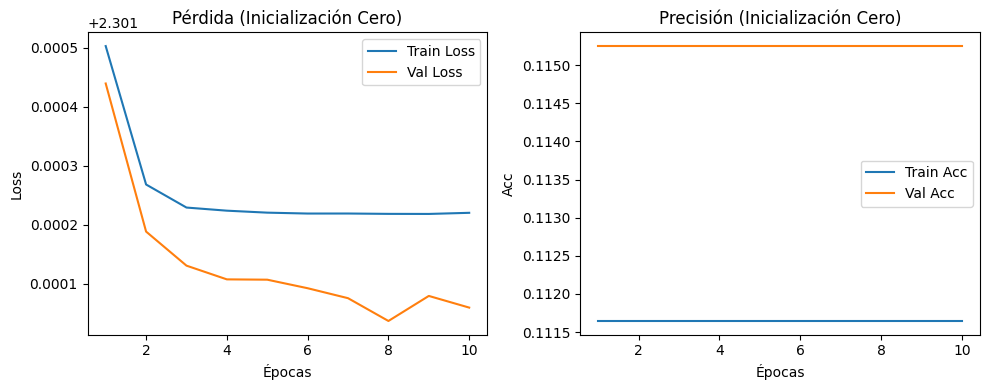

Pérdida final de Entrenamiento (Cero): 2.3012, Precisión final de Entrenamiento (Cero): 0.1116
Pérdida final de Validación (Cero): 2.3011, Precisión final de Validación (Cero): 0.1153


In [6]:
# Experimento: Inicialización con pesos a 0
train_losses_zero, train_accs_zero, val_losses_zero, val_accs_zero = run_experiment(init_weights_zero, "Cero", epochs=10)

# Graficar las curvas para este experimento
epochs_range = range(1, 11)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses_zero, label='Train Loss')
plt.plot(epochs_range, val_losses_zero, label='Val Loss')
plt.title('Pérdida (Inicialización Cero)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs_zero, label='Train Acc')
plt.plot(epochs_range, val_accs_zero, label='Val Acc')
plt.title('Precisión (Inicialización Cero)')
plt.xlabel('Épocas')
plt.ylabel('Acc')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Pérdida final de Entrenamiento (Cero): {train_losses_zero[-1]:.4f}, Precisión final de Entrenamiento (Cero): {train_accs_zero[-1]:.4f}")
print(f"Pérdida final de Validación (Cero): {val_losses_zero[-1]:.4f}, Precisión final de Validación (Cero): {val_accs_zero[-1]:.4f}")

### 2) Inicialización uniforme con pesos a 1

Inicialización Uno - Época 1/10 | Train Loss: 2.3015 | Train Acc: 0.1116 | Val Loss: 2.3015 | Val Acc: 0.1153
Inicialización Uno - Época 2/10 | Train Loss: 2.3013 | Train Acc: 0.1116 | Val Loss: 2.3012 | Val Acc: 0.1153
Inicialización Uno - Época 3/10 | Train Loss: 2.3012 | Train Acc: 0.1116 | Val Loss: 2.3011 | Val Acc: 0.1153
Inicialización Uno - Época 4/10 | Train Loss: 2.3012 | Train Acc: 0.1116 | Val Loss: 2.3011 | Val Acc: 0.1153
Inicialización Uno - Época 5/10 | Train Loss: 2.3012 | Train Acc: 0.1116 | Val Loss: 2.3011 | Val Acc: 0.1153
Inicialización Uno - Época 6/10 | Train Loss: 2.3012 | Train Acc: 0.1116 | Val Loss: 2.3011 | Val Acc: 0.1153
Inicialización Uno - Época 7/10 | Train Loss: 2.3012 | Train Acc: 0.1116 | Val Loss: 2.3011 | Val Acc: 0.1153
Inicialización Uno - Época 8/10 | Train Loss: 2.3012 | Train Acc: 0.1116 | Val Loss: 2.3011 | Val Acc: 0.1153
Inicialización Uno - Época 9/10 | Train Loss: 2.3012 | Train Acc: 0.1116 | Val Loss: 2.3011 | Val Acc: 0.1153
Inicializa

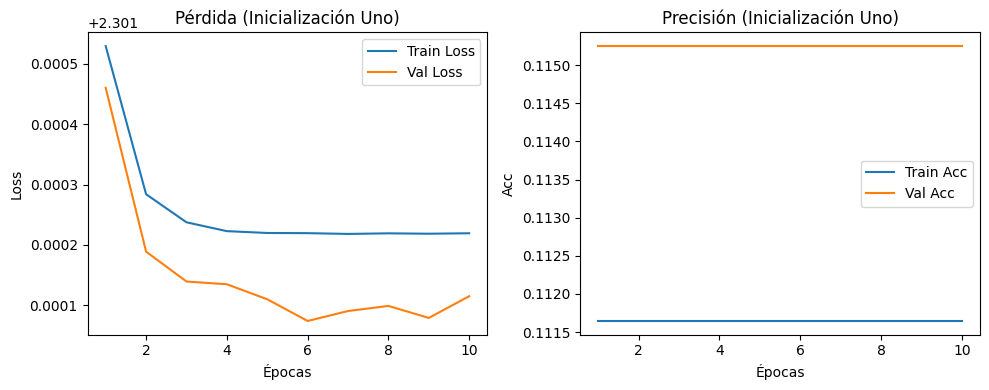

Pérdida final de Entrenamiento (Uno): 2.3012, Precisión final de Entrenamiento (Uno): 0.1116
Pérdida final de Validación (Uno): 2.3011, Precisión final de Validación (Uno): 0.1153


In [7]:
# Experimento: Inicialización con pesos a 1
train_losses_one, train_accs_one, val_losses_one, val_accs_one = run_experiment(init_weights_one, "Uno", epochs=10)

# Graficar las curvas para este experimento
epochs_range = range(1, 11)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses_one, label='Train Loss')
plt.plot(epochs_range, val_losses_one, label='Val Loss')
plt.title('Pérdida (Inicialización Uno)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs_one, label='Train Acc')
plt.plot(epochs_range, val_accs_one, label='Val Acc')
plt.title('Precisión (Inicialización Uno)')
plt.xlabel('Épocas')
plt.ylabel('Acc')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Pérdida final de Entrenamiento (Uno): {train_losses_one[-1]:.4f}, Precisión final de Entrenamiento (Uno): {train_accs_one[-1]:.4f}")
print(f"Pérdida final de Validación (Uno): {val_losses_one[-1]:.4f}, Precisión final de Validación (Uno): {val_accs_one[-1]:.4f}")

### 3) Inicialización con distribución normal N(0,1)

Inicialización N(0,1) - Época 1/10 | Train Loss: 2.4302 | Train Acc: 0.3780 | Val Loss: 2.9476 | Val Acc: 0.3770
Inicialización N(0,1) - Época 2/10 | Train Loss: 1.9121 | Train Acc: 0.4060 | Val Loss: 2.3948 | Val Acc: 0.4032
Inicialización N(0,1) - Época 3/10 | Train Loss: 1.6747 | Train Acc: 0.4606 | Val Loss: 2.2101 | Val Acc: 0.4586
Inicialización N(0,1) - Época 4/10 | Train Loss: 1.5268 | Train Acc: 0.5070 | Val Loss: 2.0625 | Val Acc: 0.4992
Inicialización N(0,1) - Época 5/10 | Train Loss: 1.4412 | Train Acc: 0.5285 | Val Loss: 2.0540 | Val Acc: 0.5192
Inicialización N(0,1) - Época 6/10 | Train Loss: 1.3983 | Train Acc: 0.5375 | Val Loss: 1.9698 | Val Acc: 0.5265
Inicialización N(0,1) - Época 7/10 | Train Loss: 1.3789 | Train Acc: 0.5635 | Val Loss: 2.0199 | Val Acc: 0.5513
Inicialización N(0,1) - Época 8/10 | Train Loss: 1.2821 | Train Acc: 0.5837 | Val Loss: 1.9152 | Val Acc: 0.5694
Inicialización N(0,1) - Época 9/10 | Train Loss: 1.2059 | Train Acc: 0.6036 | Val Loss: 1.8633 |

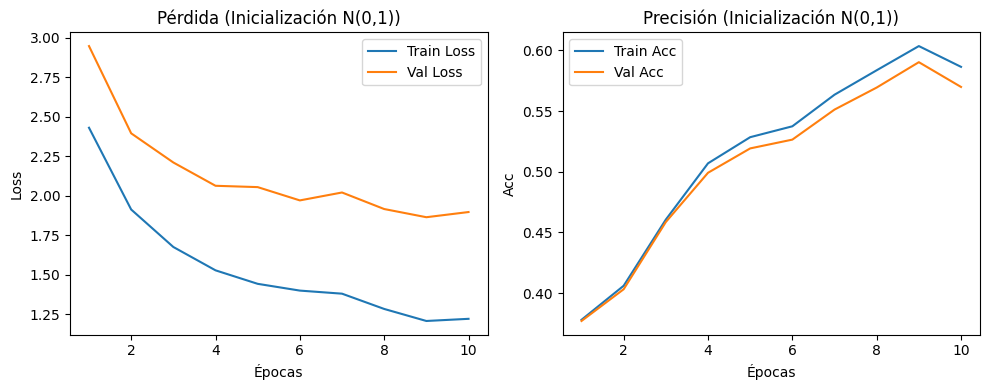

Pérdida final de Entrenamiento (N(0,1)): 1.2195, Precisión final de Entrenamiento (N(0,1)): 0.5865
Pérdida final de Validación (N(0,1)): 1.8961, Precisión final de Validación (N(0,1)): 0.5699


In [8]:
# Experimento: Inicialización con distribución normal N(0,1)
train_losses_normal, train_accs_normal, val_losses_normal, val_accs_normal = run_experiment(init_weights_normal, "N(0,1)", epochs=10)

# Graficar las curvas para este experimento
epochs_range = range(1, 11)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses_normal, label='Train Loss')
plt.plot(epochs_range, val_losses_normal, label='Val Loss')
plt.title('Pérdida (Inicialización N(0,1))')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs_normal, label='Train Acc')
plt.plot(epochs_range, val_accs_normal, label='Val Acc')
plt.title('Precisión (Inicialización N(0,1))')
plt.xlabel('Épocas')
plt.ylabel('Acc')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Pérdida final de Entrenamiento (N(0,1)): {train_losses_normal[-1]:.4f}, Precisión final de Entrenamiento (N(0,1)): {train_accs_normal[-1]:.4f}")
print(f"Pérdida final de Validación (N(0,1)): {val_losses_normal[-1]:.4f}, Precisión final de Validación (N(0,1)): {val_accs_normal[-1]:.4f}")

### 4) Inicialización Xavier Glorot con distribución normal

Inicialización Xavier - Época 1/10 | Train Loss: 0.2734 | Train Acc: 0.9215 | Val Loss: 0.2892 | Val Acc: 0.9154
Inicialización Xavier - Época 2/10 | Train Loss: 0.2058 | Train Acc: 0.9417 | Val Loss: 0.2259 | Val Acc: 0.9359
Inicialización Xavier - Época 3/10 | Train Loss: 0.1692 | Train Acc: 0.9518 | Val Loss: 0.1957 | Val Acc: 0.9443
Inicialización Xavier - Época 4/10 | Train Loss: 0.1491 | Train Acc: 0.9573 | Val Loss: 0.1818 | Val Acc: 0.9489
Inicialización Xavier - Época 5/10 | Train Loss: 0.1261 | Train Acc: 0.9646 | Val Loss: 0.1627 | Val Acc: 0.9530
Inicialización Xavier - Época 6/10 | Train Loss: 0.1123 | Train Acc: 0.9679 | Val Loss: 0.1504 | Val Acc: 0.9572
Inicialización Xavier - Época 7/10 | Train Loss: 0.1001 | Train Acc: 0.9715 | Val Loss: 0.1426 | Val Acc: 0.9583
Inicialización Xavier - Época 8/10 | Train Loss: 0.0911 | Train Acc: 0.9746 | Val Loss: 0.1378 | Val Acc: 0.9585
Inicialización Xavier - Época 9/10 | Train Loss: 0.0806 | Train Acc: 0.9775 | Val Loss: 0.1291 |

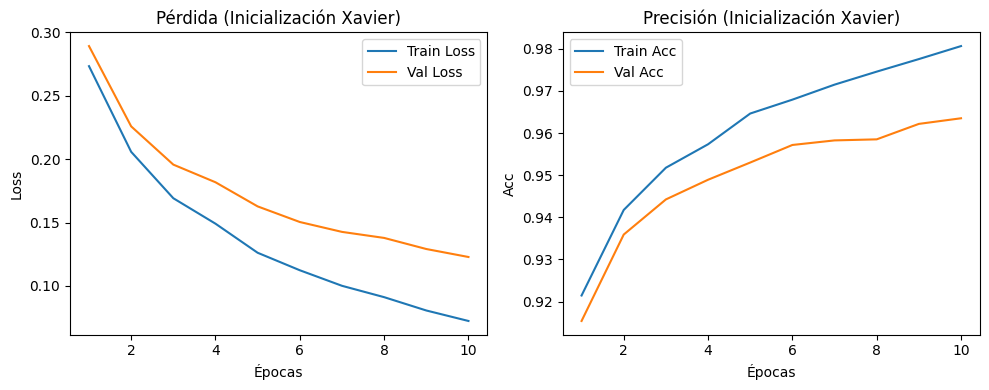

Pérdida final de Entrenamiento (Xavier): 0.0723, Precisión final de Entrenamiento (Xavier): 0.9806
Pérdida final de Validación (Xavier): 0.1228, Precisión final de Validación (Xavier): 0.9635


In [9]:
# Experimento: Inicialización Xavier Normal
train_losses_xavier, train_accs_xavier, val_losses_xavier, val_accs_xavier = run_experiment(init_weights_xavier, "Xavier", epochs=10)

# Graficar las curvas para este experimento
epochs_range = range(1, 11)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses_xavier, label='Train Loss')
plt.plot(epochs_range, val_losses_xavier, label='Val Loss')
plt.title('Pérdida (Inicialización Xavier)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs_xavier, label='Train Acc')
plt.plot(epochs_range, val_accs_xavier, label='Val Acc')
plt.title('Precisión (Inicialización Xavier)')
plt.xlabel('Épocas')
plt.ylabel('Acc')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Pérdida final de Entrenamiento (Xavier): {train_losses_xavier[-1]:.4f}, Precisión final de Entrenamiento (Xavier): {train_accs_xavier[-1]:.4f}")
print(f"Pérdida final de Validación (Xavier): {val_losses_xavier[-1]:.4f}, Precisión final de Validación (Xavier): {val_accs_xavier[-1]:.4f}")

### 5) Inicialización He/Kaiming normal 

Inicialización He/Kaiming - Época 1/10 | Train Loss: 0.2652 | Train Acc: 0.9225 | Val Loss: 0.2835 | Val Acc: 0.9163
Inicialización He/Kaiming - Época 2/10 | Train Loss: 0.2006 | Train Acc: 0.9420 | Val Loss: 0.2244 | Val Acc: 0.9349
Inicialización He/Kaiming - Época 3/10 | Train Loss: 0.1634 | Train Acc: 0.9529 | Val Loss: 0.1933 | Val Acc: 0.9432
Inicialización He/Kaiming - Época 4/10 | Train Loss: 0.1396 | Train Acc: 0.9602 | Val Loss: 0.1739 | Val Acc: 0.9495
Inicialización He/Kaiming - Época 5/10 | Train Loss: 0.1267 | Train Acc: 0.9642 | Val Loss: 0.1632 | Val Acc: 0.9527
Inicialización He/Kaiming - Época 6/10 | Train Loss: 0.1084 | Train Acc: 0.9700 | Val Loss: 0.1475 | Val Acc: 0.9547
Inicialización He/Kaiming - Época 7/10 | Train Loss: 0.0985 | Train Acc: 0.9721 | Val Loss: 0.1419 | Val Acc: 0.9583
Inicialización He/Kaiming - Época 8/10 | Train Loss: 0.0873 | Train Acc: 0.9755 | Val Loss: 0.1333 | Val Acc: 0.9598
Inicialización He/Kaiming - Época 9/10 | Train Loss: 0.0787 | Tr

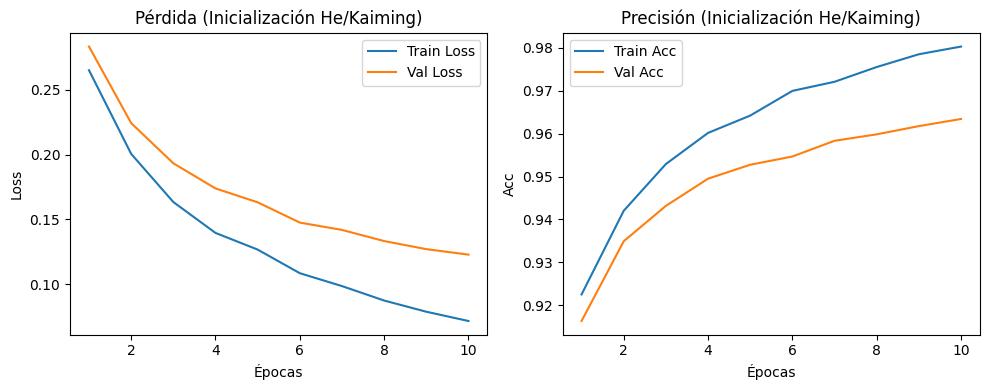

Pérdida final de Entrenamiento (He/Kaiming): 0.0715, Precisión final de Entrenamiento (He/Kaiming): 0.9803
Pérdida final de Validación (He/Kaiming): 0.1228, Precisión final de Validación (He/Kaiming): 0.9634


In [10]:
# Experimento: Inicialización He/Kaiming Normal
train_losses_kaiming, train_accs_kaiming, val_losses_kaiming, val_accs_kaiming = run_experiment(init_weights_kaiming, "He/Kaiming", epochs=10)

# Graficar las curvas para este experimento
epochs_range = range(1, 11)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses_kaiming, label='Train Loss')
plt.plot(epochs_range, val_losses_kaiming, label='Val Loss')
plt.title('Pérdida (Inicialización He/Kaiming)')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs_kaiming, label='Train Acc')
plt.plot(epochs_range, val_accs_kaiming, label='Val Acc')
plt.title('Precisión (Inicialización He/Kaiming)')
plt.xlabel('Épocas')
plt.ylabel('Acc')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Pérdida final de Entrenamiento (He/Kaiming): {train_losses_kaiming[-1]:.4f}, Precisión final de Entrenamiento (He/Kaiming): {train_accs_kaiming[-1]:.4f}")
print(f"Pérdida final de Validación (He/Kaiming): {val_losses_kaiming[-1]:.4f}, Precisión final de Validación (He/Kaiming): {val_accs_kaiming[-1]:.4f}")

## Comparación final

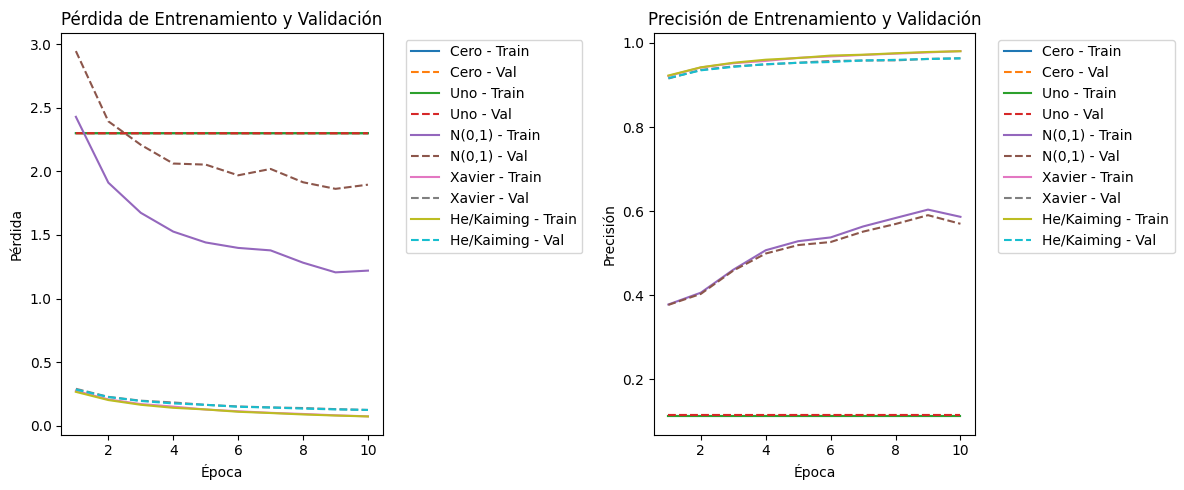

In [13]:
# Graficar las curvas de entrenamiento y validación
epochs = 10
epochs_range = range(1, epochs+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses_zero, label='Cero - Train', linestyle='-')
plt.plot(epochs_range, val_losses_zero, label='Cero - Val', linestyle='--')
plt.plot(epochs_range, train_losses_one, label='Uno - Train', linestyle='-')
plt.plot(epochs_range, val_losses_one, label='Uno - Val', linestyle='--')
plt.plot(epochs_range, train_losses_normal, label='N(0,1) - Train', linestyle='-')
plt.plot(epochs_range, val_losses_normal, label='N(0,1) - Val', linestyle='--')
plt.plot(epochs_range, train_losses_xavier, label='Xavier - Train', linestyle='-')
plt.plot(epochs_range, val_losses_xavier, label='Xavier - Val', linestyle='--')
plt.plot(epochs_range, train_losses_kaiming, label='He/Kaiming - Train', linestyle='-')
plt.plot(epochs_range, val_losses_kaiming, label='He/Kaiming - Val', linestyle='--')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs_zero, label='Cero - Train', linestyle='-')
plt.plot(epochs_range, val_accs_zero, label='Cero - Val', linestyle='--')
plt.plot(epochs_range, train_accs_one, label='Uno - Train', linestyle='-')
plt.plot(epochs_range, val_accs_one, label='Uno - Val', linestyle='--')
plt.plot(epochs_range, train_accs_normal, label='N(0,1) - Train', linestyle='-')
plt.plot(epochs_range, val_accs_normal, label='N(0,1) - Val', linestyle='--')
plt.plot(epochs_range, train_accs_xavier, label='Xavier - Train', linestyle='-')
plt.plot(epochs_range, val_accs_xavier, label='Xavier - Val', linestyle='--')
plt.plot(epochs_range, train_accs_kaiming, label='He/Kaiming - Train', linestyle='-')
plt.plot(epochs_range, val_accs_kaiming, label='He/Kaiming - Val', linestyle='--')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión de Entrenamiento y Validación')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

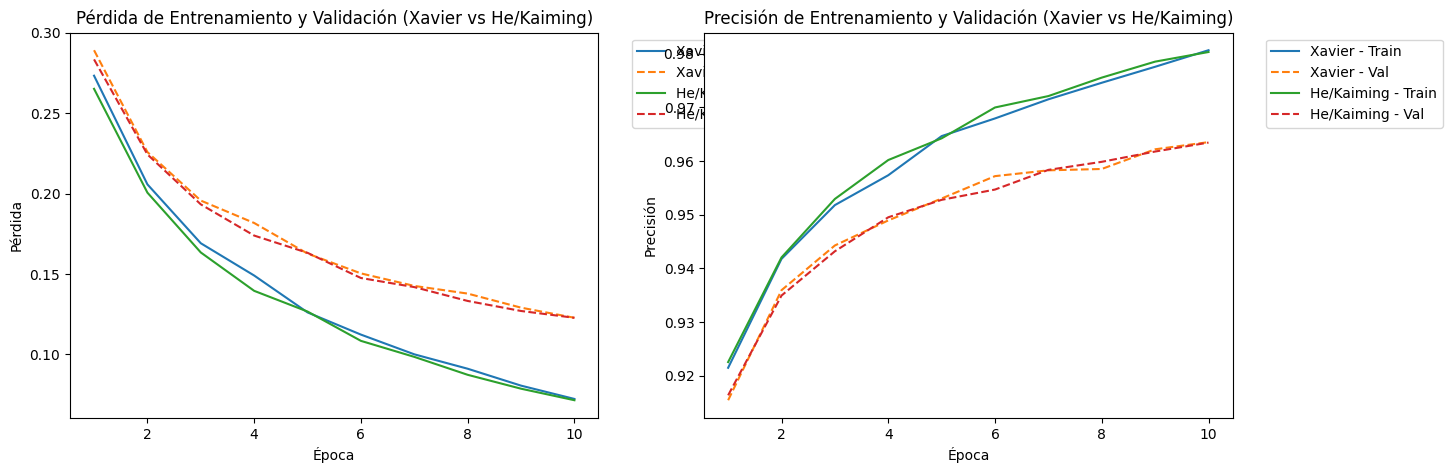

In [15]:
# Comparación solo entre Xavier y He/Kaiming
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses_xavier, label='Xavier - Train', linestyle='-')
plt.plot(epochs_range, val_losses_xavier, label='Xavier - Val', linestyle='--')
plt.plot(epochs_range, train_losses_kaiming, label='He/Kaiming - Train', linestyle='-')
plt.plot(epochs_range, val_losses_kaiming, label='He/Kaiming - Val', linestyle='--')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación (Xavier vs He/Kaiming)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs_xavier, label='Xavier - Train', linestyle='-')
plt.plot(epochs_range, val_accs_xavier, label='Xavier - Val', linestyle='--')
plt.plot(epochs_range, train_accs_kaiming, label='He/Kaiming - Train', linestyle='-')
plt.plot(epochs_range, val_accs_kaiming, label='He/Kaiming - Val', linestyle='--')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión de Entrenamiento y Validación (Xavier vs He/Kaiming)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

## Conclusión

- **Pesos a 0**: El modelo no aprende eficazmente debido a la falta de ruptura de simetría. La precisión se mantendrá cerca del azar.
- **Pesos a 1**: Similarmente, la inicialización a constantes tiene el mismo problema que a ceros y la red no puede aprender.
- **Normal $N(0,1)$**: Puede permitir algún aprendizaje, pero podría ser demasiado agresiva dependiendo del tamaño de la red. Los pesos iniciales grandes pueden provocar inestabilidad. No es óptima.
- **Xavier Normal**: Diseñada para mantener la varianza estable a lo largo de la red, generalmente ofrece resultados de entrenamiento más sólidos.
- **He/Kaiming Normal**: Óptima para activaciones ReLU, ayuda a mantener gradientes estables y facilita el entrenamiento de redes profundas con funciones de activación tipo ReLU.

# Batch normalization

Batch Normalization es una técnica que normaliza las activaciones de una capa para cada mini-lote, acelerando el entrenamiento y mejorando la estabilidad del modelo.
 
Beneficios:
- Permite utilizar tasas de aprendizaje más altas.
- Reduce la sensibilidad a la inicialización de los pesos.
- Actúa como una forma de regularización, reduciendo el sobreajuste.
 
Para una activación $x$ en una capa:
$$
\hat{x} = \frac{x - \mu_{\text{batch}}}{\sqrt{\sigma_{\text{batch}}^2 + \epsilon}}
$$
$$
y = \gamma \hat{x} + \beta
$$
Donde:
- $\mu_{\text{batch}}$ y $\sigma_{\text{batch}}^2$ son la media y varianza del mini-lote.
- $\epsilon$ es un pequeño valor para estabilidad numérica.
- $\gamma$ y $\beta$ son parámetros aprendibles que permiten al modelo deshacer la normalización si es necesario.

In [17]:
# -----------------------------------------------------------
# Batch Normalization
# -----------------------------------------------------------

# Definir el modelo MLP con Batch Normalization
class MLPBatchNorm(nn.Module):
    def __init__(self, input_size=28*28, hidden_sizes=[256, 128], num_classes=10):
        super(MLPBatchNorm, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_sizes[1], num_classes)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Definir la función de entrenamiento
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * data.size(0)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

# Crear instancias de los modelos con y sin Batch Normalization
model_default = MLP().to(device)
model_batchnorm = MLPBatchNorm().to(device)

# Utilizar la inicialización por defecto de PyTorch
# (PyTorch utiliza una inicialización uniforme basada en Kaiming para nn.Linear)

# Definir el criterio y los optimizadores
optimizer_default = optim.SGD(model_default.parameters(), lr=0.01)
optimizer_batchnorm = optim.SGD(model_batchnorm.parameters(), lr=0.01)

# Criterio de pérdida
criterion = nn.CrossEntropyLoss()

# Listas para almacenar las pérdidas y precisiones
train_losses_default = []
train_accs_default = []
val_losses_default = []
val_accs_default = []

train_losses_batchnorm = []
train_accs_batchnorm = []
val_losses_batchnorm = []
val_accs_batchnorm = []

# Entrenamiento del modelo sin Batch Normalization
print("\nEntrenando el modelo sin Batch Normalization...")
for epoch in range(num_epochs):
    # Entrenamiento
    train_loss = train(model_default, device, train_loader, optimizer_default, criterion)
    
    # Evaluación en entrenamiento
    train_loss_eval, train_acc = evaluate(model_default, device, train_loader, criterion)
    train_losses_default.append(train_loss_eval)
    train_accs_default.append(train_acc)
    
    # Evaluación en validación
    val_loss, val_acc = evaluate(model_default, device, val_loader, criterion)
    val_losses_default.append(val_loss)
    val_accs_default.append(val_acc)
    
    print(f"Época {epoch+1}/{num_epochs}, Pérdida de Entrenamiento: {train_loss_eval:.4f}, Precisión de Entrenamiento: {train_acc:.4f}, "
          f"Pérdida de Validación: {val_loss:.4f}, Precisión de Validación: {val_acc:.4f}")

# Entrenamiento del modelo con Batch Normalization
print("\nEntrenando el modelo con Batch Normalization...")
for epoch in range(num_epochs):
    # Entrenamiento
    train_loss = train(model_batchnorm, device, train_loader, optimizer_batchnorm, criterion)
    
    # Evaluación en entrenamiento
    train_loss_eval, train_acc = evaluate(model_batchnorm, device, train_loader, criterion)
    train_losses_batchnorm.append(train_loss_eval)
    train_accs_batchnorm.append(train_acc)
    
    # Evaluación en validación
    val_loss, val_acc = evaluate(model_batchnorm, device, val_loader, criterion)
    val_losses_batchnorm.append(val_loss)
    val_accs_batchnorm.append(val_acc)
    
    print(f"Época {epoch+1}/{num_epochs}, Pérdida de Entrenamiento: {train_loss_eval:.4f}, Precisión de Entrenamiento: {train_acc:.4f}, "
          f"Pérdida de Validación: {val_loss:.4f}, Precisión de Validación: {val_acc:.4f}")


Entrenando el modelo sin Batch Normalization...
Época 1/20, Pérdida de Entrenamiento: 0.3798, Precisión de Entrenamiento: 0.8925, Pérdida de Validación: 0.3900, Precisión de Validación: 0.8883
Época 2/20, Pérdida de Entrenamiento: 0.2968, Precisión de Entrenamiento: 0.9135, Pérdida de Validación: 0.3078, Precisión de Validación: 0.9091
Época 3/20, Pérdida de Entrenamiento: 0.2501, Precisión de Entrenamiento: 0.9270, Pérdida de Validación: 0.2649, Precisión de Validación: 0.9235
Época 4/20, Pérdida de Entrenamiento: 0.2185, Precisión de Entrenamiento: 0.9370, Pérdida de Validación: 0.2351, Precisión de Validación: 0.9323
Época 5/20, Pérdida de Entrenamiento: 0.1944, Precisión de Entrenamiento: 0.9437, Pérdida de Validación: 0.2133, Precisión de Validación: 0.9391
Época 6/20, Pérdida de Entrenamiento: 0.1724, Precisión de Entrenamiento: 0.9506, Pérdida de Validación: 0.1932, Precisión de Validación: 0.9454
Época 7/20, Pérdida de Entrenamiento: 0.1549, Precisión de Entrenamiento: 0.9561,

### Comparación batch normalization

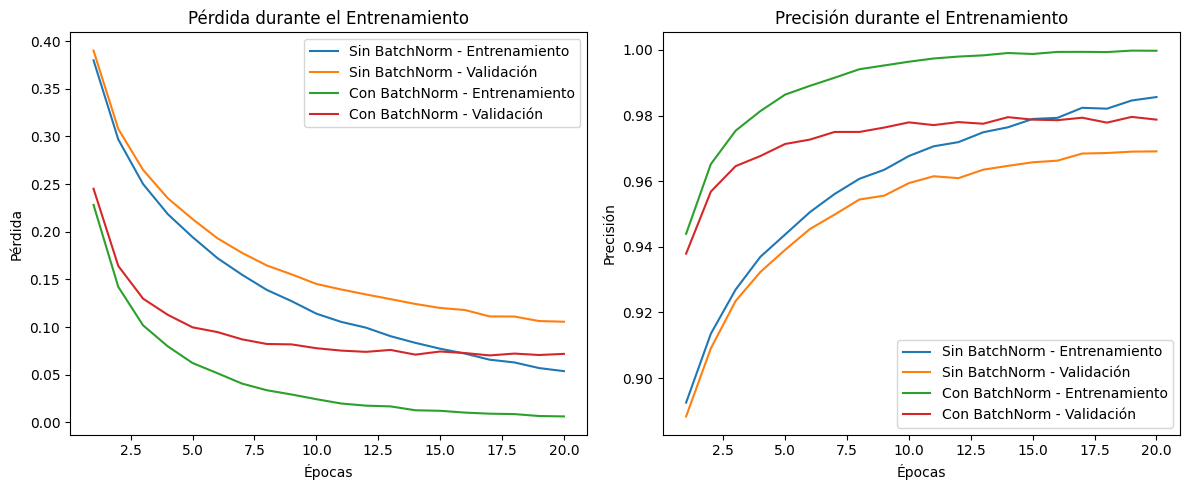

In [18]:
# Crear listas de épocas
epochs_range = range(1, num_epochs + 1)

# Graficar las pérdidas de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses_default, label='Sin BatchNorm - Entrenamiento')
plt.plot(epochs_range, val_losses_default, label='Sin BatchNorm - Validación')
plt.plot(epochs_range, train_losses_batchnorm, label='Con BatchNorm - Entrenamiento')
plt.plot(epochs_range, val_losses_batchnorm, label='Con BatchNorm - Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el Entrenamiento')
plt.legend()

# Graficar las precisiones de entrenamiento
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs_default, label='Sin BatchNorm - Entrenamiento')
plt.plot(epochs_range, val_accs_default, label='Sin BatchNorm - Validación')
plt.plot(epochs_range, train_accs_batchnorm, label='Con BatchNorm - Entrenamiento')
plt.plot(epochs_range, val_accs_batchnorm, label='Con BatchNorm - Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión durante el Entrenamiento')
plt.legend()

plt.tight_layout()
plt.show()

## Conclusiones

- Sin Batch Normalization:
  El modelo puede tener un entrenamiento más lento y ser más sensible a la inicialización y a la tasa de aprendizaje.
  Puede experimentar problemas de covariate shift interno, donde las distribuciones de las activaciones cambian durante el entrenamiento.

- Con Batch Normalization:
  El modelo suele entrenar más rápido y alcanzar mejores precisiones en menos épocas.
  Es más robusto a la inicialización y permite el uso de tasas de aprendizaje más altas.
  Ayuda a reducir el sobreajuste al actuar como una forma de regularización, aunque en este ejemplo no lo mitiga en absoluto.